In [2]:
!pip install torchsummary

In [66]:
!pip install torch-summary

In [1]:
import numpy as np
import pandas as pd

import pydicom as dicom
import matplotlib.pylab as plt
import matplotlib.patches as patches

import pickle

import os
from os import listdir
from os.path import isfile, join

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.models import resnet18


from torchsummary import summary

import gc
gc.collect()

import cv2

from sklearn.model_selection import train_test_split

from tqdm import tqdm
from tqdm.auto import tqdm as tqdm_
from tqdm.notebook import tqdm as tqdm_step

from PIL import Image

import matplotlib.pyplot as plt
from IPython.display import clear_output

from graphviz import Digraph

In [2]:
print(f"Cuda доступна {torch.cuda.is_available()}. Версия cuda {torch.version.cuda}")

gpu_id = 0
gpu_str = "cuda:{}".format(gpu_id)
device = torch.device(gpu_str if torch.cuda.is_available() else "cpu")

x_cpu = torch.ones((3, 3))
idx_cpus = set()
devices_cpu = {}
devices_gpu = {}

for idx in range(1000):
    device = torch.device(f"cpu:{idx}")
    x_cpu = x_cpu.to(device)
    if id(x_cpu) not in idx_cpus:
        idx_cpus.add(id(x_cpu))
        devices_cpu[f"cpu:{idx}"] = device
        print("x_cpu:{} device: {} is_cuda: {} id: {}".format(idx, x_cpu.device, x_cpu.is_cuda, id(x_cpu)))
    else:
        break
        
device_count = torch.cuda.device_count()

print("\ndevice_count: {}".format(device_count))

print(f"Используется cuda:{torch.cuda.current_device()}")
print(torch.cuda.device_count())

for idx in range(torch.cuda.device_count()):
    try:
        device = torch.device(f"cuda:{idx}")
        x_gpu = x_cpu.to(device)
        print("x_gpu:\ndevice: {} is_cuda: {} id: {}".format(x_gpu.device, x_gpu.is_cuda, id(x_gpu)))
        device_name = torch.cuda.get_device_name(idx)
        print("\ndevice_name {}: {}".format(idx, device_name))
        #print(torch.cuda.memory_stats(device))
        print(torch.cuda.get_device_capability(idx))
        devices_gpu[f"cuda:{idx}"] = (device_name, device)
    except Exception as e:
        print(f"Карта {idx} не отвечает - {e}")

Cuda доступна True. Версия cuda 10.2
x_cpu:0 device: cpu is_cuda: False id: 140458791644992
x_cpu:1 device: cpu is_cuda: False id: 140458791436752

device_count: 4
Используется cuda:0
4
x_gpu:
device: cuda:0 is_cuda: True id: 140458791371376

device_name 0: Tesla M40 24GB
(5, 2)
x_gpu:
device: cuda:1 is_cuda: True id: 140458791641872

device_name 1: Tesla M40
(5, 2)
x_gpu:
device: cuda:2 is_cuda: True id: 140458791371376

device_name 2: Tesla M40 24GB
(5, 2)
x_gpu:
device: cuda:3 is_cuda: True id: 140458791641872

device_name 3: NVIDIA GeForce GT 1030
(6, 1)


In [3]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
params = {
    "data_pandas":"",
    "dicom_path":"./CT_TUBERCULOSIS (1)/CT_TUBERCULOSIS_anon/",
    "size":128,
    'batch_size':8,
    'num_workers':4,
    "epoch":5,
    'device':torch.device("cuda:1" if torch.cuda.is_available() else "cpu"),
}

In [5]:
params["device"]

device(type='cuda', index=1)

In [6]:
params['device'] != "cpu"

True

In [7]:
params['data_pandas'] =  os.path.join(params["dicom_path"], [f for f in listdir(params["dicom_path"]) if isfile(join(params["dicom_path"], f)) if f.split('.')[-1] == 'xlsx'][0])

(512, 512)


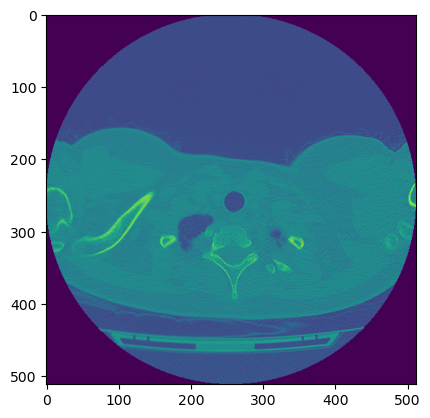

In [8]:
image_path = os.path.join(params["dicom_path"],'1.2.643.5.1.13.13.12.2.77.8252.07011304111203070701030403031010/1.2.643.5.1.13.13.12.2.77.8252.02121010060208081005130614081409/1.2.643.5.1.13.13.12.2.77.8252.00001015010106011314141106080815.dcm')
ds = dicom.dcmread(image_path)
print(np.shape(ds.pixel_array))
plt.imshow(ds.pixel_array);

In [9]:
ds.fix_meta_info

/home/arhitegio/anaconda3/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00001015010106011314141106080815'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/arhitegio/anaconda3/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: The value length (156) exceeds the maximum length of 64 allowed for VR LO.
  warnings.warn(msg)
/home/arhitegio/anaconda3/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.07011304111203070701030403031010'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/arhitegio/anaconda3/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.0

<bound method Dataset.fix_meta_info of Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 230
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.643.5.1.13.13.12.2.77.8252.00001015010106011314141106080815
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.392.200036.9116.2.6.1.100
(0002, 0013) Implementation Version Name         SH: 'TM_CT_CMW_V3.00'
(0002, 0016) Source Application Entity Title     AE: 'Aquilion_GP68'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 192'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UI

In [10]:
xl = pd.ExcelFile(params["data_pandas"])
xl.sheet_names

['Sheet1']

In [11]:
df = xl.parse(xl.sheet_names[0])
df.head()

,Unnamed: 0,study_instance,pathology
0,0,1.2.643.5.1.13.13.12.2.77.8252.150102051513061...,1
1,1,1.2.643.5.1.13.13.12.2.77.8252.120003110002060...,1
2,2,1.2.643.5.1.13.13.12.2.77.8252.080806080802140...,0
3,3,1.2.643.5.1.13.13.12.2.77.8252.070113041112030...,0


In [12]:
df[df.columns[1:]].to_numpy()

array([['1.2.643.5.1.13.13.12.2.77.8252.15010205151306100605140610071503',
        1],
       ['1.2.643.5.1.13.13.12.2.77.8252.12000311000206060603090803041306',
        1],
       ['1.2.643.5.1.13.13.12.2.77.8252.08080608080214000814110410100908',
        0],
       ['1.2.643.5.1.13.13.12.2.77.8252.07011304111203070701030403031010',
        0]], dtype=object)

In [13]:
files = [{"study_instance":dp.split('/')[-2], "path_dicom":os.path.join(dp, f)} for dp, dn, filenames in os.walk(params["dicom_path"]) for f in filenames if os.path.splitext(f)[1] == '.dcm']

In [14]:
df_ = pd.DataFrame(files)

In [15]:
data = df_.merge(df[df.columns[1:]], how='inner', on="study_instance")

In [16]:
data

,study_instance,path_dicom,pathology
0,1.2.643.5.1.13.13.12.2.77.8252.070113041112030...,./CT_TUBERCULOSIS (1)/CT_TUBERCULOSIS_anon/1.2...,0
1,1.2.643.5.1.13.13.12.2.77.8252.070113041112030...,./CT_TUBERCULOSIS (1)/CT_TUBERCULOSIS_anon/1.2...,0
2,1.2.643.5.1.13.13.12.2.77.8252.070113041112030...,./CT_TUBERCULOSIS (1)/CT_TUBERCULOSIS_anon/1.2...,0
3,1.2.643.5.1.13.13.12.2.77.8252.070113041112030...,./CT_TUBERCULOSIS (1)/CT_TUBERCULOSIS_anon/1.2...,0
4,1.2.643.5.1.13.13.12.2.77.8252.070113041112030...,./CT_TUBERCULOSIS (1)/CT_TUBERCULOSIS_anon/1.2...,0
...,...,...,...
3480,1.2.643.5.1.13.13.12.2.77.8252.080806080802140...,./CT_TUBERCULOSIS (1)/CT_TUBERCULOSIS_anon/1.2...,0
3481,1.2.643.5.1.13.13.12.2.77.8252.080806080802140...,./CT_TUBERCULOSIS (1)/CT_TUBERCULOSIS_anon/1.2...,0
3482,1.2.643.5.1.13.13.12.2.77.8252.080806080802140...,./CT_TUBERCULOSIS (1)/CT_TUBERCULOSIS_anon/1.2...,0
3483,1.2.643.5.1.13.13.12.2.77.8252.080806080802140...,./CT_TUBERCULOSIS (1)/CT_TUBERCULOSIS_anon/1.2...,0


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3485 entries, 0 to 3484
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   study_instance  3485 non-null   object
 1   path_dicom      3485 non-null   object
 2   pathology       3485 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 108.9+ KB


In [18]:
params['all_class'] = np.unique(data["pathology"])

In [19]:
data.groupby(data["study_instance"]).agg({"pathology":["count"]})

,pathology
,count
study_instance,
1.2.643.5.1.13.13.12.2.77.8252.07011304111203070701030403031010,914
1.2.643.5.1.13.13.12.2.77.8252.08080608080214000814110410100908,1332
1.2.643.5.1.13.13.12.2.77.8252.12000311000206060603090803041306,788
1.2.643.5.1.13.13.12.2.77.8252.15010205151306100605140610071503,451


In [20]:
data.groupby(data["pathology"]).agg({"study_instance":["count"]})

,study_instance
,count
pathology,
0,2246
1,1239


<AxesSubplot:>

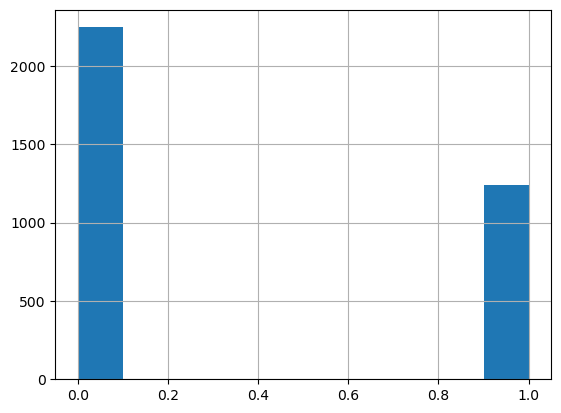

In [21]:
data["pathology"].hist()

In [22]:
train_df, valid_df = train_test_split(data, test_size=0.2, random_state=43)

In [23]:
dicom_path, label = train_df.iloc[0]['path_dicom'], train_df.iloc[0]['pathology']

In [24]:
dicom_image = Image.fromarray(dicom.dcmread(dicom_path).pixel_array)

In [25]:
arr = dicom.dcmread(dicom_path).pixel_array

In [26]:
np.min(arr), np.max(arr), np.median(arr), np.mean(arr)

(-2048, 1525, -974.0, -877.0437812805176)

In [27]:
glb_ = { "min":[], "max":[], "mean":[], "median":[] }

In [28]:
pbar_progress = tqdm_step(range(len(train_df)), desc="Прогресс")

for idx in pbar_progress:
    dicom_path, label = train_df.iloc[idx]['path_dicom'], train_df.iloc[idx]['pathology']
    arr = dicom.dcmread(dicom_path).pixel_array
    glb_['min'].append(np.min(arr))
    glb_['max'].append(np.max(arr))
    glb_['median'].append(np.median(arr))
    glb_['mean'].append(np.mean(arr))

Прогресс:   0%|          | 0/2788 [00:00<?, ?it/s]

In [29]:
class ImageDataset(Dataset):
    def __init__(self, data_df, transform=None):

        self.data_df = data_df
        self.transform = transform
        
    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        
        dicom_path, label = self.data_df.iloc[idx]['path_dicom'], self.data_df.iloc[idx]['pathology']
        
        dicom_image = Image.fromarray(dicom.dcmread(dicom_path).pixel_array)

        if self.transform:
            dicom_image = self.transform(dicom_image)
        #print(torch.typename(dicom_image))
        return dicom_image.float(), torch.tensor(np.array([1.0 if idx == label else 0.0 for idx, e in enumerate(range(len(params['all_class'])))])), dicom_path

In [30]:
df_gbl = pd.DataFrame(glb_)

In [31]:
df_gbl

,min,max,mean,median
0,-2048,1525,-877.043781,-974.0
1,-2048,1375,-837.066326,-887.0
2,-2048,1378,-943.224491,-980.0
3,-2048,1761,-783.994934,-880.0
4,-2048,1319,-929.252708,-938.0
...,...,...,...,...
2783,-2048,1653,-970.867687,-975.0
2784,-2048,1964,-851.983170,-900.0
2785,-2096,1698,-675.112789,-376.0
2786,-2048,1254,-817.730370,-886.0


In [32]:
train_transform = transforms.Compose([
    #trf.ToPILImage(),
    transforms.Resize((params['size'], params['size'])),
    #trf.Resize((512, 512)),
    #transforms.Resize((int(params['size'] * 1.3), int(params['size'] * 1.3))),
    #trf.Resize((int(params['size']), int(params['size']))),
    #transforms.RandomCrop((params['size'], params['size'])),
    transforms.RandomRotation(degrees=5.0, fill=np.min(df_gbl['min'])),
    transforms.RandomAffine(degrees=(-2,2), translate=(0, 0.15), scale=(0.90, 1.0), fill=np.min(df_gbl['min'])),
    #trf.RandomApply(transforms=[trf.ElasticTransform(alpha=50.0)], p=0.5),
    transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.02, hue=0.02), 
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225]),
])
valid_transform = transforms.Compose([
    #transforms.ToPILImage(),
    transforms.Resize((params['size'], params['size'])),
    #transforms.RandomResizedCrop(params['size']),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225]),
])

In [33]:
train_df.groupby('pathology').agg({"study_instance":["count"]}), valid_df.groupby('pathology').agg({"study_instance":["count"]})

(          study_instance
                    count
 pathology               
 0                   1800
 1                    988,
           study_instance
                    count
 pathology               
 0                    446
 1                    251)

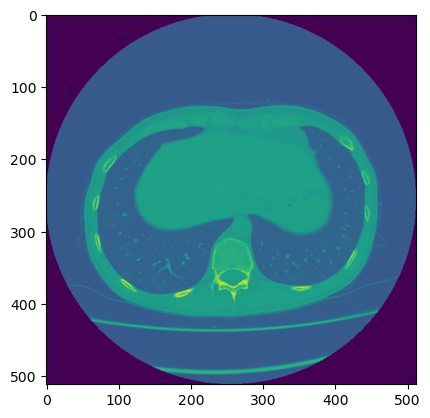

In [34]:
plt.imshow(dicom.dcmread(dicom_path).pixel_array)
plt.show();

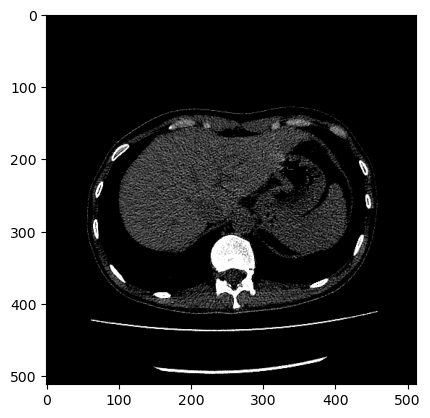

In [35]:
plt.imshow(dicom_image)
plt.show();

In [36]:
train_dataset = ImageDataset(train_df, train_transform)

In [37]:
valid_dataset = ImageDataset(valid_df, valid_transform)

In [38]:
img, lbl, name_file = train_dataset[150]

In [39]:
np.shape(np.moveaxis(img.numpy(), 0, -1))

(128, 128, 1)

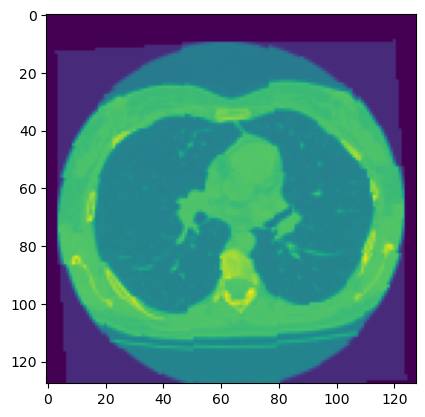

In [40]:
plt.imshow(np.moveaxis(img.numpy(), 0, -1));

In [41]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=params['batch_size'],
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=params['num_workers'])

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=params['batch_size'],
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=params['num_workers'])

In [42]:
batch_size = 4
epochs = 10
epoch_lapse = 50
threshold = 0.5
sample_size = None

In [43]:
def metric_delta_cross(y_true, pred, device):
    mask = (y_true == 1)
    pred_outer = pred.clone().detach()
    mask_field = torch.Tensor(np.ones(y_true.shape)).to(device)
    pred_outer[mask] = 0
    mask_field[mask] = 0
    pred[~mask] = 0
    outer = 1 - (torch.sum(torch.sum(torch.sum(pred_outer, dim=1), dim=1), dim=1)+1e-16) / (torch.sum(torch.sum(torch.sum(mask_field, dim=1), dim=1), dim=1)+1e-16)
    inner = 1 - (torch.sum(torch.sum(torch.sum(torch.abs(y_true - pred), dim=1), dim=1), dim=1)+1e-16) / (torch.sum(torch.sum(torch.sum(mask.long(), dim=1), dim=1), dim=1)+1e-16)
    metric = torch.mean((outer + inner) / 2)
    return torch.Tensor([0]) if metric < 0 else metric

In [44]:
def metric_accuracy(y_true, pred, device):
    return torch.mean(torch.argmax(y_true, dim=0) == torch.argmax(pred, dim=0))
    pass

In [45]:
a = torch.tensor(np.array([[[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0]]]))
b = torch.tensor(np.array([[[0,1],[0,1],[1,0],[0,1],[1,0],[0,1],[1,0],[1,0]]]))
a = a.moveaxis(-1,0)
b = b.moveaxis(-1,0)
metric_accuracy(a,b,"cpu")

tensor(0.5000)

In [46]:
class DownSampling(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, device):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels, padding=1)
        self.conv1.to(device)
        self.bn2d1 = torch.nn.BatchNorm2d(out_channels)
        self.bn2d1.to(device)
        self.conv2 = torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels, padding=1)
        self.conv2.to(device)
        self.bn2d2 = torch.nn.BatchNorm2d(out_channels)
        self.bn2d2.to(device)

    def forward(self, inp):
        out = torch.nn.functional.relu(self.conv1(inp))
        out = self.bn2d1(out)
        out = torch.nn.functional.relu(self.conv2(out))
        out = self.bn2d2(out)
        return out

In [73]:
class FinalBlock(nn.Module):
    def __init__(self, in_channels, mid_channel, out_channels, kernel_size, device):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding=1)
        self.conv1.to(device)
        self.bn2d1 = torch.nn.BatchNorm2d(mid_channel)
        self.bn2d1.to(device)
        self.conv2 = torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel, padding=1)
        self.conv2.to(device)
        self.bn2d2 = torch.nn.BatchNorm2d(mid_channel)
        self.bn2d2.to(device)
        self.conv3 = torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=1)
        self.conv3.to(device)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(1083, 128)
        self.linear1.to(device)
        self.linear2 = nn.Linear(128, 32)
        self.linear2.to(device)
        self.linear3 = nn.Linear(32, len(params["all_class"]))
        self.linear3.to(device)
        
    def forward(self, inp):
        out = torch.nn.functional.relu(self.conv1(inp))
        out = self.bn2d1(out)
        out = torch.nn.functional.relu(self.conv2(out))
        out = self.bn2d2(out)
        out = torch.sigmoid(self.conv3(out))
        out = self.flatten(out)
        out = torch.sigmoid(self.linear1(out))
        out = torch.sigmoid(self.linear2(out))
        out = torch.nn.functional.softmax(self.linear3(out))
        return out

In [74]:
class UNet(nn.Module):    
    def __init__(self, in_channels, out_channels, device):
        super(UNet, self).__init__()
        self.conv1 = DownSampling(in_channels, 24, 3, device)
        self.conv1.to(device)
        self.conv2 = DownSampling(24, 16, 3, device)
        self.conv2.to(device)
        self.conv3 = DownSampling(16, 12, 3, device)
        self.conv3.to(device)
        self.final = FinalBlock(12, 8, 3, out_channels, device)
        self.final.to(device)
        self.conv_maxpool = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_maxpool.to(device)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv_maxpool(x)
        x = self.conv2(x)
        x = self.conv_maxpool(x)
        x = self.conv3(x)
        x = self.conv_maxpool(x)
        x = self.final(x)
        return x

In [75]:
def step(inputs, labels, optimizer, criterion, device, is_train=True):
    #if is_train:
    optimizer.zero_grad()

    outputs = unet(inputs)
    #print(np.shape(outputs), np.shape(labels))
    #outputs = outputs.permute(0, 2, 3, 1)
    #labels = labels.permute(0, 2, 3, 1)
    
    #loss = criterion(torch.argmax(outputs, dim=0).float(), torch.argmax(labels.float(), dim=0).float())
    loss = criterion(outputs, labels.float())
    
    if is_train:
        loss.backward()
        optimizer.step()
    return loss.item(), metric_accuracy(labels, outputs, device).item()

In [50]:
learning_rate = 0.0001

In [51]:
params['all_class']

array([0, 1])

In [76]:
unet = UNet(in_channels=1,out_channels=np.shape(params['all_class'])[-1], device=params["device"])
#if params['device'] != "cpu":
#unet = unet.to(params["device"])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(unet.parameters(), lr = learning_rate)

In [53]:
with open("model.pkl", "rb") as f:
    unet = pickle.load(f)

In [167]:
with open("model.pkl", "wb") as f:
    pickle.dump(unet, f)

In [53]:
unet.to(params["device"])

UNet(
  (conv1): DownSampling(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2d1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2d2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): DownSampling(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2d1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2d2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): DownSampling(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2d1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(256, 256, kernel_size=(3

In [54]:
acc_train_total = []
loss_train_total = []
acc_val_total = []
loss_val_total = []

In [172]:
try:
    print(unet.load_state_dict(torch.load('./best_model_tuber.mdl')))
except:
    print("Модель не загрузилась")

<All keys matched successfully>


In [173]:
try:
    acc_train_total = list(np.load('acc_tuber_train_total.npy'))
    loss_train_total = list(np.load('loss_tuber_train_total.npy'))
    acc_val_total = list(np.load('acc_tuber_val_total.npy'))
    loss_val_total = list(np.load('loss_tuber_val_total.npy'))
except:
    print("Данные не загрузилась")

In [185]:
learning_rate = 0.00005

In [186]:
criterion = nn.BCELoss()

In [187]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(unet.parameters(), lr = learning_rate)

In [86]:
list(loss_val_total)

[[0.222931965846907,
  0.08425345110960981,
  0.04991049171340736,
  0.03305715999820016,
  0.16174505394883454],
 [0.018170243192633443,
  0.01362010234416547,
  0.010588967812840234,
  0.028908749396743424,
  0.0075321773130616],
 [0.009644360440275208,
  0.005221674996639856,
  0.004327914291273125,
  0.0037974293809384108,
  0.003176793165039271],
 [0.0027077522668564184,
  0.003440261289308017,
  0.0020837779791856356,
  0.0018020806191171605,
  0.0015553192351944745],
 [0.0013422754101074215,
  0.0011504539248893377,
  0.0009853531863138248,
  0.0008430868878018704,
  0.0007192258854047395],
 [0.0006143780119600706,
  0.0005219602164949968,
  0.0004449799201789905,
  0.0003775929405740251,
  0.0003193458952327174],
 [0.3188192377036268,
  0.31668568131598557,
  0.32021019099788234,
  0.31338703259825706,
  0.31335948035120964],
 [0.3133522004566409,
  0.31904659928245976,
  0.3133359920572151,
  0.3133262253620408,
  0.31331919777122413],
 [0.31334591047330335,
  0.31389850344170

In [87]:
params["device"]

device(type='cuda', index=1)

In [97]:
%%time

acc_train  = []
loss_train = []
acc_val    = []
loss_val   = []
batch_loss = 0
metric_acc = 0
pbar_epochs = tqdm_step(range(params["epoch"]), desc="Epochs")
for _ in pbar_epochs:
    unet.train()
    bar_train_loss = []
    bar_train_acc = []
    pbar_steps = tqdm_step(train_loader, desc="Training")
    for batch_train_x, batch_train_y, batch_train_name_file in pbar_steps:
        #batch_train_x = torch.from_numpy(x_train[i * batch_size : (i + 1) * batch_size, ...]).float()
        #batch_train_y = torch.from_numpy(y_train[i * batch_size : (i + 1) * batch_size]).long()
        #print(np.shape(batch_train_x), np.shape(batch_train_y), np.shape(batch_train_name_file))
        #if use_gpu:
        batch_train_x = batch_train_x.to(params["device"])
        batch_train_y = batch_train_y.to(params["device"])
        batch_loss, metric_acc = step(batch_train_x, batch_train_y, optimizer, criterion, params["device"], is_train=True)
        bar_train_loss.append(batch_loss)
        bar_train_acc.append(metric_acc)
        pbar_steps.postfix = f"loss = {batch_loss}, acc = {metric_acc*100}%, loss_mean = {np.mean(bar_train_loss)}, acc_mean = {np.mean(bar_train_acc)*100}%"     
        torch.cuda.empty_cache()
        gc.collect()
        #break
    loss_train.append(np.mean(bar_train_loss))
    acc_train.append(np.mean(bar_train_acc))
    
    unet.eval()
    with torch.no_grad():
        pbar_vals = tqdm_step(valid_loader, desc="Predicting")
        bar_val_loss = []
        bar_val_acc = []
        for batch_val_x, batch_val_y, batch_val_name_file in pbar_vals:
            #try:
                #print(np.shape(batch_val_x), np.shape(batch_val_y), np.shape(batch_val_name_file))
                #batch_val_x = torch.from_numpy(x_val[i * batch_size : (i + 1) * batch_size, ...]).float()
                #batch_val_y = torch.from_numpy(y_val[i * batch_size : (i + 1) * batch_size]).long()
                #if use_gpu:
                batch_val_x = batch_val_x.to(params["device"])
                batch_val_y = batch_val_y.to(params["device"])
                batch_loss, metric_acc = step(batch_val_x, batch_val_y, optimizer, criterion, params["device"], is_train=False)
                bar_val_loss.append(batch_loss)
                bar_val_acc.append(metric_acc)
                pbar_vals.postfix = f"loss = {batch_loss},  acc = {metric_acc*100}%, loss_mean = {np.mean(bar_val_loss)}, acc_mean = {np.mean(bar_val_acc)*100}%"
                torch.cuda.empty_cache()
                gc.collect()
            #except Exception as e:
            #    print(e)
    loss_val.append(np.mean(bar_val_loss))
    acc_val.append(np.mean(bar_val_acc))
    pbar_epochs.postfix = f"train_loss = {loss_train[-1]}, train_acc = {acc_train[-1]*100}%, val_loss = {loss_val[-1]}, val_acc = {acc_val[-1]*100}%"
acc_train_total.append(acc_train)
loss_train_total.append(loss_train)
acc_val_total.append(acc_val)
loss_val_total.append(loss_val)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/349 [00:00<?, ?it/s]

/tmp/ipykernel_8709/3022222193.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(self.linear3(out))


Predicting:   0%|          | 0/88 [00:00<?, ?it/s]

Training:   0%|          | 0/349 [00:00<?, ?it/s]

Predicting:   0%|          | 0/88 [00:00<?, ?it/s]

Training:   0%|          | 0/349 [00:00<?, ?it/s]

Predicting:   0%|          | 0/88 [00:00<?, ?it/s]

Training:   0%|          | 0/349 [00:00<?, ?it/s]

Predicting:   0%|          | 0/88 [00:00<?, ?it/s]

Training:   0%|          | 0/349 [00:00<?, ?it/s]

Predicting:   0%|          | 0/88 [00:00<?, ?it/s]

CPU times: user 4min 44s, sys: 17.7 s, total: 5min 2s
Wall time: 4min 59s


In [188]:
%%time

acc_train  = []
loss_train = []
acc_val    = []
loss_val   = []
batch_loss = 0
metric_acc = 0
pbar_epochs = tqdm_step(range(params["epoch"]), desc="Epochs")
for _ in pbar_epochs:
    unet.train()
    bar_train_loss = []
    bar_train_acc = []
    pbar_steps = tqdm_step(train_loader, desc="Training")
    for batch_train_x, batch_train_y, batch_train_name_file in pbar_steps:
        #batch_train_x = torch.from_numpy(x_train[i * batch_size : (i + 1) * batch_size, ...]).float()
        #batch_train_y = torch.from_numpy(y_train[i * batch_size : (i + 1) * batch_size]).long()
        #print(np.shape(batch_train_x), np.shape(batch_train_y), np.shape(batch_train_name_file))
        #if use_gpu:
        batch_train_x = batch_train_x.to(params["device"])
        batch_train_y = batch_train_y.to(params["device"])
        batch_loss, metric_acc = step(batch_train_x, batch_train_y, optimizer, criterion, params["device"], is_train=True)
        bar_train_loss.append(batch_loss)
        bar_train_acc.append(metric_acc)
        pbar_steps.postfix = f"loss = {batch_loss}, acc = {metric_acc*100}%, loss_mean = {np.mean(bar_train_loss)}, acc_mean = {np.mean(bar_train_acc)*100}%"     
        torch.cuda.empty_cache()
        gc.collect()
        #break
    loss_train.append(np.mean(bar_train_loss))
    acc_train.append(np.mean(bar_train_acc))
    
    unet.eval()
    with torch.no_grad():
        pbar_vals = tqdm_step(valid_loader, desc="Predicting")
        bar_val_loss = []
        bar_val_acc = []
        for batch_val_x, batch_val_y, batch_val_name_file in pbar_vals:
            #try:
                #print(np.shape(batch_val_x), np.shape(batch_val_y), np.shape(batch_val_name_file))
                #batch_val_x = torch.from_numpy(x_val[i * batch_size : (i + 1) * batch_size, ...]).float()
                #batch_val_y = torch.from_numpy(y_val[i * batch_size : (i + 1) * batch_size]).long()
                #if use_gpu:
                batch_val_x = batch_val_x.to(params["device"])
                batch_val_y = batch_val_y.to(params["device"])
                batch_loss, metric_acc = step(batch_val_x, batch_val_y, optimizer, criterion, params["device"], is_train=False)
                bar_val_loss.append(batch_loss)
                bar_val_acc.append(metric_acc)
                pbar_vals.postfix = f"loss = {batch_loss},  acc = {metric_acc*100}%, loss_mean = {np.mean(bar_val_loss)}, acc_mean = {np.mean(bar_val_acc)*100}%"
                torch.cuda.empty_cache()
                gc.collect()
            #except Exception as e:
            #    print(e)
    loss_val.append(np.mean(bar_val_loss))
    acc_val.append(np.mean(bar_val_acc))
    pbar_epochs.postfix = f"train_loss = {loss_train[-1]}, train_acc = {acc_train[-1]*100}%, val_loss = {loss_val[-1]}, val_acc = {acc_val[-1]*100}%"
acc_train_total.append(acc_train)
loss_train_total.append(loss_train)
acc_val_total.append(acc_val)
loss_val_total.append(loss_val)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/349 [00:00<?, ?it/s]

/tmp/ipykernel_8709/3022222193.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(self.linear3(out))


Predicting:   0%|          | 0/88 [00:00<?, ?it/s]

Training:   0%|          | 0/349 [00:00<?, ?it/s]

Predicting:   0%|          | 0/88 [00:00<?, ?it/s]

Training:   0%|          | 0/349 [00:00<?, ?it/s]

Predicting:   0%|          | 0/88 [00:00<?, ?it/s]

Training:   0%|          | 0/349 [00:00<?, ?it/s]

Predicting:   0%|          | 0/88 [00:00<?, ?it/s]

Training:   0%|          | 0/349 [00:00<?, ?it/s]

Predicting:   0%|          | 0/88 [00:00<?, ?it/s]

CPU times: user 4min 56s, sys: 17.7 s, total: 5min 13s
Wall time: 5min 10s


In [168]:
torch.save(unet.state_dict(), './best_model_tuber.mdl')

In [170]:
#with open("./last.state", "w") as f:
#    f.write(json.dumps({"val_acc":val_acc.item()}))
if os.path.exists("./best_model_tuber.mdl"):
    os.rename('./best_model_tuber.mdl', f'./model_tuber_{1}.mdl')
torch.save(unet.state_dict(), './best_model_tuber.mdl')
print('Сохранено!')

Сохранено!


In [171]:
with open('acc_tuber_train_total.npy', 'wb') as f:
    np.save(f, np.hstack(acc_train_total))
with open('acc_tuber_val_total.npy', 'wb') as f:
    np.save(f, np.hstack(acc_val_total))
with open('loss_tuber_train_total.npy', 'wb') as f:
    np.save(f, np.hstack(loss_train_total))
with open('loss_tuber_val_total.npy', 'wb') as f:
    np.save(f, np.hstack(loss_val_total))

In [102]:
acc_train = [e if e >= 0 else 0 for e in acc_train]
loss_train = [e if e >= 0 else 0 for e in loss_train]

In [103]:
x = [e for e in range(len(np.hstack(acc_train_total)))]

In [104]:
def plot_examples(dataset, num_examples=5):
    fig, ax = plt.subplots(nrows=1, ncols=num_examples, figsize=(18,4*num_examples))
    m = len(dataset)
    p = 0.4
    for row_idx in range(num_examples):
        image_indx = np.random.randint(m)
        x, y, name_file = dataset[image_indx]
        shp = np.shape(x)
        x = torch.tensor(np.array([x.detach().cpu().numpy()])).to(params["device"])
        y_pred = unet(x.to(params["device"])).squeeze(0).detach().cpu().numpy()
        ax[row_idx].imshow(x.cpu()[0][0])
        ax[row_idx].set_title(f"{str(row_idx)} {np.argmax(y)} {('=' if np.argmax(y) == np.argmax(y_pred) else '!=')} {np.argmax(y_pred)}")
        rect = patches.Rectangle((0, 0), shp[1], shp[-1], linewidth=5, edgecolor='r' if np.argmax(y) != np.argmax(y_pred) else 'g', facecolor='none')
        ax[row_idx].add_patch(rect)
        #cs = ax[row_idx].contourf(h, levels=[10, 30, 50], colors=['#808080', '#A0A0A0', '#C0C0C0'], extend='both')
        #cs.cmap.set_over('red')
        #cs.cmap.set_under('blue')
        #cs.changed()
    plt.show()

/tmp/ipykernel_8709/3022222193.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(self.linear3(out))


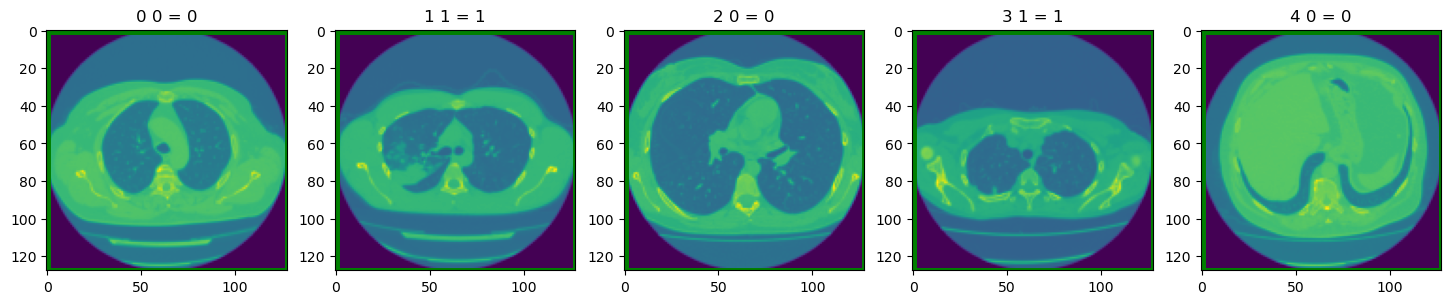

In [118]:
plot_examples(valid_dataset)

In [190]:
arr_pred = []
y_true = []
y_pred = []
for idx in range(len(valid_dataset)):
    x, y, name_file = valid_dataset[idx]
    x = torch.tensor(np.array([x.detach().cpu().numpy()])).to(params["device"])
    y_p = unet(x.to(params["device"])).squeeze(0).detach().cpu().numpy()
    y_true.append(np.argmax(y).item())
    y_pred.append(np.argmax(y_p))
    arr_pred.append(np.argmax(y).item() == np.argmax(y_p))

/tmp/ipykernel_8709/3022222193.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(self.linear3(out))


In [191]:
len([e for e in zip(y_true, y_pred) if e[0] == e[1]])

697

In [192]:
len([e for e in zip(y_true, y_pred) if e[0] == e[1] and e[0] == 1])

251

In [193]:
len([e for e in zip(y_true, y_pred) if e[0] != e[1]])

0

In [194]:
from sklearn.metrics import f1_score, accuracy_score

In [195]:
print(f"F1 = {f1_score(y_true, y_pred, average='macro')}, точность = {accuracy_score(y_true, y_pred)}")

F1 = 1.0, точность = 1.0


In [196]:
print("Максимальная точность на тренировочных примерах: ")
print("точность: " + str(np.max(np.hstack(acc_train_total))) + ", loss:" + str(np.max(np.hstack(loss_train_total))))

Максимальная точность на тренировочных примерах: 
точность: 0.7392550143266475, loss:0.5722469894967994


In [197]:
print("Максимальная точность на тестовых примерах: ")
print("точность: " + str(np.max(np.hstack(acc_val_total))) + ", loss:" + str(np.max(np.hstack(loss_val_total))))

Максимальная точность на тестовых примерах: 
точность: 0.8863636363636364, loss:0.5834325125271623


In [198]:
print("Средняя точность на тренировочных из 10 последних примеров: ")
print("точность: " + str(np.mean(np.hstack(acc_train_total[-10:-1]))) + ", loss:" + str(np.mean(np.hstack(loss_train_total[-10:-1]))))

Средняя точность на тренировочных из 10 последних примеров: 
точность: 0.6419702551507709, loss:0.31356048325770774


In [199]:
print("Средняя точность на тестовых из 10 последних примеров: ")
print("точность: " + str(np.mean(np.hstack(acc_val_total[-10:-1]))) + ", loss:" + str(np.mean(np.hstack(loss_val_total[-10:-1]))))

Средняя точность на тестовых из 10 последних примеров: 
точность: 0.7624458874458875, loss:0.31326541262658647


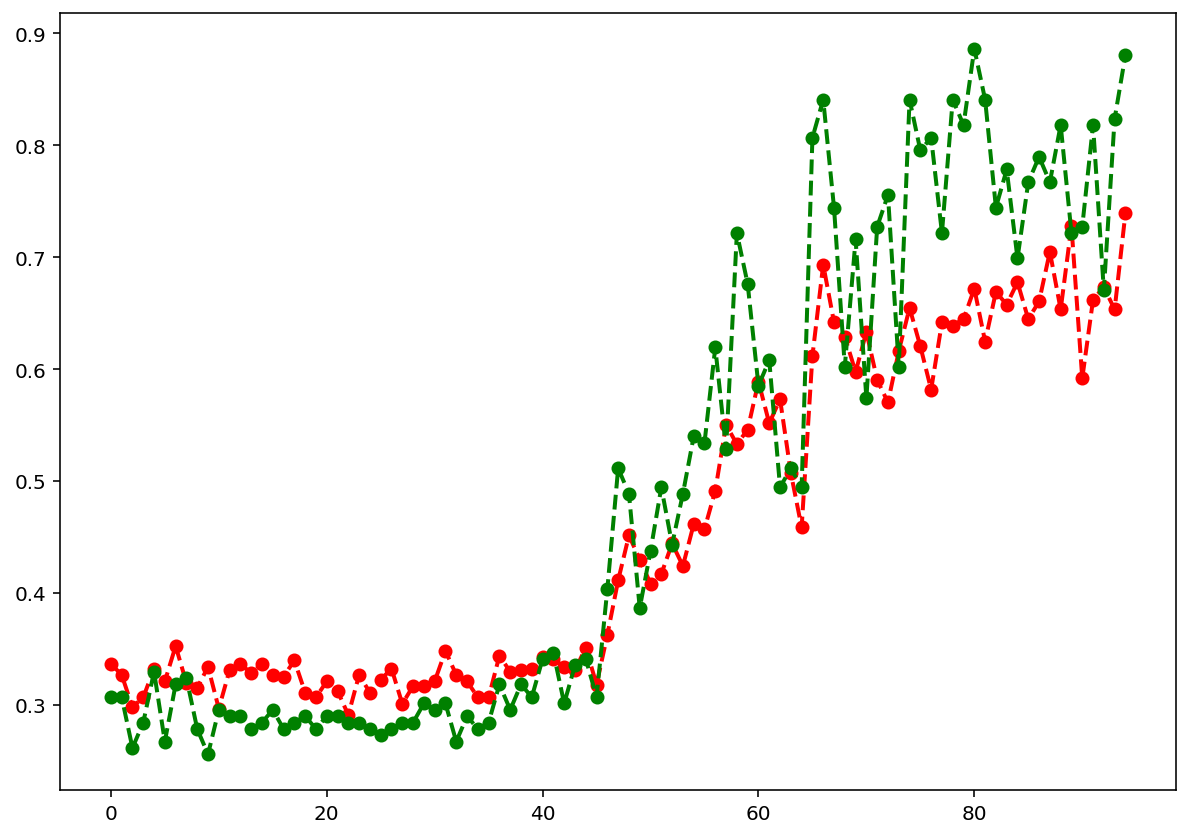

In [200]:
plt.figure(figsize=(10,7), dpi=144)
plt.plot([e for e in range(np.shape(np.hstack(acc_train_total))[0])], np.hstack(acc_train_total), color='red', marker='o', linestyle='dashed', linewidth=2, markersize=6)
plt.plot([e for e in range(np.shape(np.hstack(acc_val_total))[0])], np.hstack(acc_val_total), color='green', marker='o', linestyle='dashed', linewidth=2, markersize=6)
plt.show()

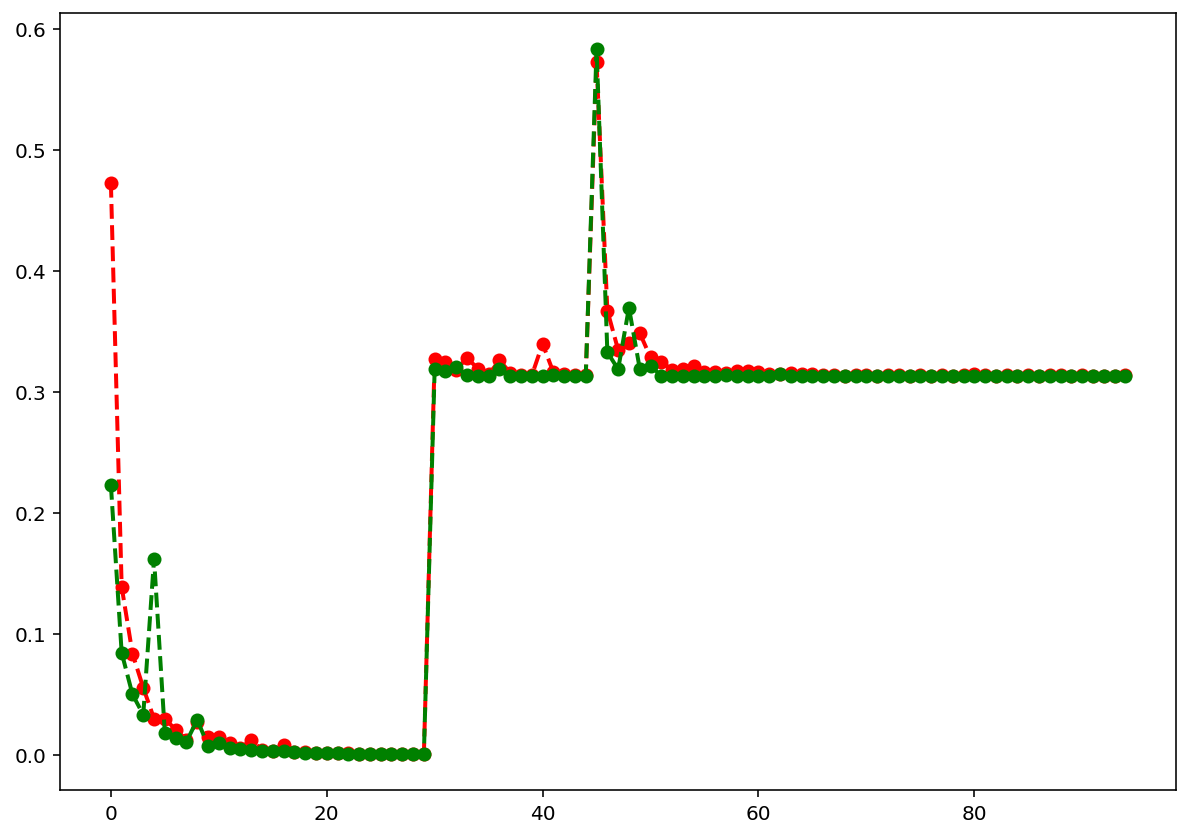

In [201]:
plt.figure(figsize=(10,7), dpi=144)
plt.plot([e for e in range(np.shape(np.hstack(loss_train_total))[0])], np.hstack(loss_train_total), color='red', marker='o', linestyle='dashed', linewidth=2, markersize=6)
plt.plot([e for e in range(np.shape(np.hstack(loss_val_total))[0])], np.hstack(loss_val_total), color='green', marker='o', linestyle='dashed', linewidth=2, markersize=6)
plt.show()

In [202]:
from os import listdir
from os.path import isfile, join

In [203]:

mypath = "./test"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles

['1.2.643.5.1.13.13.12.2.77.8252.04131513080315030305140908000413.dcm',
 '1.2.643.5.1.13.13.12.2.77.8252.11030011091506110107120402090008.dcm',
 '1.2.643.5.1.13.13.12.2.77.8252.12141011141401070204051309081108.dcm',
 '1.2.643.5.1.13.13.12.2.77.8252.15090704081300100900041405151505.dcm',
 '1.2.643.5.1.13.13.12.2.77.8252.00130904141401080010140710010613.dcm',
 '1.2.643.5.1.13.13.12.2.77.8252.12131406140210021104080608080500.dcm',
 '1.2.643.5.1.13.13.12.2.77.8252.11001507060705120610090511121011.dcm',
 '1.2.643.5.1.13.13.12.2.77.8252.01100901040006051405010806070707.dcm',
 '1.2.643.5.1.13.13.12.2.77.8252.08011311031004150506010804031101.dcm',
 '1.2.643.5.1.13.13.12.2.77.8252.09061114060411071108071215010907.dcm',
 '1.2.643.5.1.13.13.12.2.77.8252.01080604131407010701121110120507.dcm',
 '1.2.643.5.1.13.13.12.2.77.8252.02091512021405111213070300071009.dcm',
 '1.2.643.5.1.13.13.12.2.77.8252.08131013020705111414140611000410.dcm',
 '1.2.643.5.1.13.13.12.2.77.8252.0008031213150814111205051300050

In [204]:
params["dicom_path"]

'./CT_TUBERCULOSIS (1)/CT_TUBERCULOSIS_anon/'

In [205]:
[{"study_instance":f, "path_dicom":os.path.join(dp, f), "pathology":0} for dp, dn, filenames in os.walk(mypath) for f in onlyfiles if os.path.splitext(f)[1] == '.dcm']

[{'study_instance': '1.2.643.5.1.13.13.12.2.77.8252.04131513080315030305140908000413.dcm',
  'path_dicom': './test/1.2.643.5.1.13.13.12.2.77.8252.04131513080315030305140908000413.dcm',
  'pathology': 0},
 {'study_instance': '1.2.643.5.1.13.13.12.2.77.8252.11030011091506110107120402090008.dcm',
  'path_dicom': './test/1.2.643.5.1.13.13.12.2.77.8252.11030011091506110107120402090008.dcm',
  'pathology': 0},
 {'study_instance': '1.2.643.5.1.13.13.12.2.77.8252.12141011141401070204051309081108.dcm',
  'path_dicom': './test/1.2.643.5.1.13.13.12.2.77.8252.12141011141401070204051309081108.dcm',
  'pathology': 0},
 {'study_instance': '1.2.643.5.1.13.13.12.2.77.8252.15090704081300100900041405151505.dcm',
  'path_dicom': './test/1.2.643.5.1.13.13.12.2.77.8252.15090704081300100900041405151505.dcm',
  'pathology': 0},
 {'study_instance': '1.2.643.5.1.13.13.12.2.77.8252.00130904141401080010140710010613.dcm',
  'path_dicom': './test/1.2.643.5.1.13.13.12.2.77.8252.00130904141401080010140710010613.dcm',

In [206]:
df_test = pd.DataFrame([{"study_instance":f, "path_dicom":os.path.join(dp, f), "pathology":0} for dp, dn, filenames in os.walk(mypath) for f in onlyfiles if os.path.splitext(f)[1] == '.dcm'])

In [207]:
df_test.head(5)

,study_instance,path_dicom,pathology
0,1.2.643.5.1.13.13.12.2.77.8252.041315130803150...,./test/1.2.643.5.1.13.13.12.2.77.8252.04131513...,0
1,1.2.643.5.1.13.13.12.2.77.8252.110300110915061...,./test/1.2.643.5.1.13.13.12.2.77.8252.11030011...,0
2,1.2.643.5.1.13.13.12.2.77.8252.121410111414010...,./test/1.2.643.5.1.13.13.12.2.77.8252.12141011...,0
3,1.2.643.5.1.13.13.12.2.77.8252.150907040813001...,./test/1.2.643.5.1.13.13.12.2.77.8252.15090704...,0
4,1.2.643.5.1.13.13.12.2.77.8252.001309041414010...,./test/1.2.643.5.1.13.13.12.2.77.8252.00130904...,0


In [208]:
test_dataset = ImageDataset(df_test, valid_transform)
test_dataset

In [209]:
arr_pred_test = []
y_true_test = []
y_pred_test = []
for idx in range(len(test_dataset)):
    x, y, name_file = test_dataset[idx]
    x = torch.tensor(np.array([x.detach().cpu().numpy()])).to(params["device"])
    y_p = unet(x.to(params["device"])).squeeze(0).detach().cpu().numpy()
    y_true_test.append(np.argmax(y).item())
    y_pred_test.append(np.argmax(y_p))
    arr_pred_test.append(np.argmax(y).item() == np.argmax(y_p))

/tmp/ipykernel_8709/3022222193.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(self.linear3(out))


In [210]:
print(f"F1 = {f1_score(y_true_test, y_pred_test, average='macro')}, точность = {accuracy_score(y_true_test, y_pred_test)}")

F1 = 0.39660056657223797, точность = 0.6572769953051644
